In [34]:
import numpy as np
import pandas as pd
%matplotlib inline
import pandas_profiling
from pandas_profiling import ProfileReport

df = pd.read_csv("extract-3-very-clean.csv")

In [35]:
df.dtypes

Unnamed: 0                 int64
Property ID              float64
Download date / time      object
Property name             object
Property unit number      object
Property house number     object
Property street name      object
Property locality         object
Property post code       float64
Area                     float64
Contract date             object
Settlement date           object
Purchase price           float64
Zoning                    object
Primary purpose           object
Strata lot number        float64
dtype: object

In [36]:
property_locations = ['Hazelbrook','Woodford','Linden','Faulconbridge','Springwood','Valley Heights','Warrimoo']

postcode_min = 2750
postcode_max = 2800
area_min = 1000


df_myarea = df[(df['Property locality'].isin(property_locations)) & (df['Area'] > area_min) & (df['Property post code'] >= postcode_min) & (df['Property post code'] <= postcode_max) & (df['Primary purpose'] == 'Vacant land')]
print(str(len(df_myarea.index)) + ' records kept')

86 records kept


In [ ]:
profile = ProfileReport(df_myarea, title="Pandas Profiling Report")
profile

array([[<AxesSubplot:title={'center':'Purchase price'}>]], dtype=object)

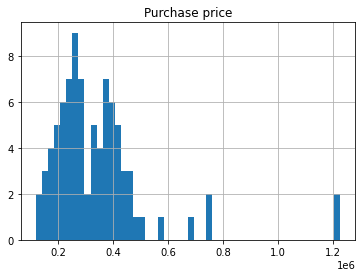

In [45]:
#df_myarea.groupby('Purchase price').count().plot(kind='bar')
df_myarea.hist(column='Purchase price', bins=50)